<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/MVTec_ResNet101V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification on recasted MVTec dataset as a supervised problem using ResNet101 architecture

In [0]:
# check GPU compatibility

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# mount drive to access the dataset through colab

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# go to the dataset directory

cd /content/drive/My Drive/data

/content/drive/My Drive/data


In [0]:
#import necessary packages

import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.applications import ResNet101V2
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

Using TensorFlow backend.


ResNet101 architecture updated in 2016 by author as **ResNet101V2** is utilized. The accuracy was found to be increased by updating the residual modules to use [identity mappings](https://arxiv.org/abs/1603.05027).

In [0]:
img_height = 224
img_width = 224

base_model = ResNet101V2(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))

In [0]:
num_classes = 30

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x=Dense(512, activation='relu')(x) 
preds = Dense(num_classes, activation= 'softmax')(x)

model = Model(inputs = base_model.input, outputs = preds)

In [0]:
# model.summary()

In [0]:
v = 0
a = model.layers
print("Total layers in ResNet101V2 : ", len(a))
for i in range(len(a)):
            if type(a[i]) == keras.layers.convolutional.Conv2D:
                v += 1
                # print(a[i])
print("No. of Conv2D layers : ", v)

Total layers in ResNet101V2 :  381
No. of Conv2D layers :  104


In [0]:
# set the base model to be not trainable

base_model.trainable = False

In [0]:
# validation split - 20 %

train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 vertical_flip=True,
                                 validation_split=0.2)

In [0]:
bs = 16                   #change batch size accordingly

CLASSES = ['defective_bottle','defective_cable','defective_capsule','defective_carpet',
           'defective_grid','defective_hazelnut','defective_leather','defective_metalnut',
           'defective_pill','defective_screw','defective_tile','defective_toothbrush',
           'defective_transistor','defective_wood','defective_zipper','good_bottle',
           'good_cable','good_capsule','good_carpet','good_grid',
           'good_hazelnut','good_leather','good_metalnut','good_pill',
           'good_screw','good_tile','good_toothbrush','good_transistor',
           'good_wood','good_zipper']

In [0]:
train_generator=train_datagen.flow_from_directory('train',  
                                                 target_size=(224,224),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training',
                                                 classes=CLASSES)

Found 2884 images belonging to 30 classes.


In [0]:
label_map = (train_generator.class_indices)
print("Label map: ",label_map)

Label map:  {'defective_bottle': 0, 'defective_cable': 1, 'defective_capsule': 2, 'defective_carpet': 3, 'defective_grid': 4, 'defective_hazelnut': 5, 'defective_leather': 6, 'defective_metalnut': 7, 'defective_pill': 8, 'defective_screw': 9, 'defective_tile': 10, 'defective_toothbrush': 11, 'defective_transistor': 12, 'defective_wood': 13, 'defective_zipper': 14, 'good_bottle': 15, 'good_cable': 16, 'good_capsule': 17, 'good_carpet': 18, 'good_grid': 19, 'good_hazelnut': 20, 'good_leather': 21, 'good_metalnut': 22, 'good_pill': 23, 'good_screw': 24, 'good_tile': 25, 'good_toothbrush': 26, 'good_transistor': 27, 'good_wood': 28, 'good_zipper': 29}


In [0]:
val_generator=train_datagen.flow_from_directory('train', 
                                                 target_size=(224,224),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 704 images belonging to 30 classes.


In [0]:
step_size_train = train_generator.n//train_generator.batch_size
print("Training step size: ",step_size_train)

step_size_val = (val_generator.n//val_generator.batch_size) + 1
print("Validation step size: ",step_size_val)

Training step size:  180
Validation step size:  45


In [0]:
# SGD optimizer is used

from keras.callbacks import LearningRateScheduler

sgd = SGD()

model.compile(optimizer= sgd, loss='categorical_crossentropy', metrics=['acc'])

In [0]:
initial_epochs = 50        #change as per requirement

import math

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.5
  drop_every = 5.0        #change as per requirement
  lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/drop_every))
  return lrate

loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs,
                   callbacks = callbacks_list)

# model.save('/content/drive/My Drive/xai_model/MVTec_RN101_50_2.h5')
# model.save_weights('/content/drive/My Drive/xai_model/MVTec_RN101_50_weights_2.h5')

Epoch 1/50
180/180 [==============================] - 215s 1s/step - loss: 1.3034 - acc: 0.6208 - val_loss: 0.7153 - val_acc: 0.7347
Epoch 2/50
180/180 [==============================] - 197s 1s/step - loss: 0.6545 - acc: 0.7337 - val_loss: 0.8470 - val_acc: 0.6792
Epoch 3/50
180/180 [==============================] - 194s 1s/step - loss: 0.5975 - acc: 0.7642 - val_loss: 0.5247 - val_acc: 0.8278
Epoch 4/50
180/180 [==============================] - 193s 1s/step - loss: 0.5462 - acc: 0.7823 - val_loss: 0.5592 - val_acc: 0.8097
Epoch 5/50
180/180 [==============================] - 192s 1s/step - loss: 0.4289 - acc: 0.8372 - val_loss: 0.4426 - val_acc: 0.8292
Epoch 6/50
180/180 [==============================] - 191s 1s/step - loss: 0.4004 - acc: 0.8358 - val_loss: 0.4571 - val_acc: 0.8361
Epoch 7/50
180/180 [==============================] - 189s 1s/step - loss: 0.3805 - acc: 0.8469 - val_loss: 0.4303 - val_acc: 0.8528
Epoch 8/50
180/180 [==============================] - 187s 1s/step - 

In [0]:
# model.save('/content/drive/My Drive/xai_model/MVTec_RN101_50.h5')
# model.save_weights('/content/drive/My Drive/xai_model/MVTec_RN101_50_weights.h5')

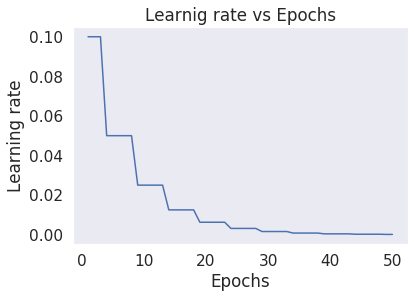

In [0]:
# plot the learning rate curve over epochs

x_axis = list(range(1,51))
y_axis = loss_history.lr
plt.plot(x_axis, y_axis)
plt.grid(None)
plt.title('Learnig rate vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
# plt.savefig('/content/drive/My Drive/xai_model/MVTec_RN101_50_2_LR.jpg')

In [0]:
# evaluating the model

scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)

print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

45/45 [==============================] - 35s 777ms/step
Validating loss: 0.2746064933120377
Validating accuracy: 0.9083333333333333


In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

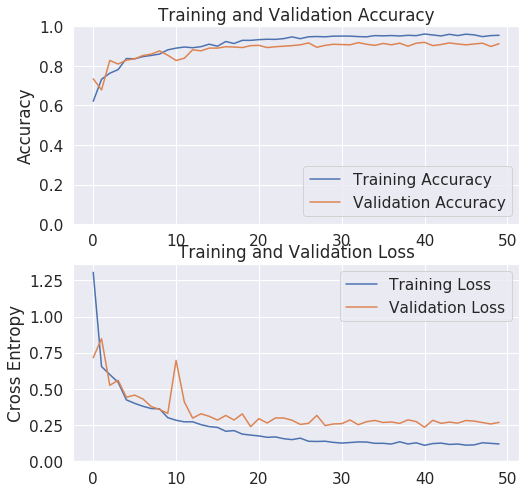

In [0]:
# plot the training and validation process' accuracy and loss

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
# plt.savefig('/content/drive/My Drive/xai_model/MVTec_RN101_50_2_accuracy.jpg')
plt.show()

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm() 

In [0]:
# !kill -9 -1

In [0]:
# model = load_model('/content/drive/My Drive/xai_model/MVTec_RN101_50.h5')

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True)

In [0]:
bs_test = 8           #change test batch size here

test_generator = test_datagen.flow_from_directory('test',
                                                  target_size=(224,224),     
                                                  batch_size=bs_test,
                                                  class_mode='categorical',
                                                  shuffle = False)

Found 1542 images belonging to 30 classes.


In [0]:
step_size_test = (test_generator.n//test_generator.batch_size)+1
print("Test step size : ", step_size_test)
test_generator.reset()

193


In [0]:
predIndxs = model.predict_generator(test_generator, steps = step_size_test, verbose=1 )

193/193 [==============================] - 80s 416ms/step


In [0]:
acc_o = np.sum(np.argmax(predIndxs, axis=1).astype('int') == test_generator.labels) / test_generator.n
print("Test Accuracy : ",acc_o)

0.920881971465629


In [0]:
# print(len(predIndxs))
# print(len(test_generator.labels))

1542
1542


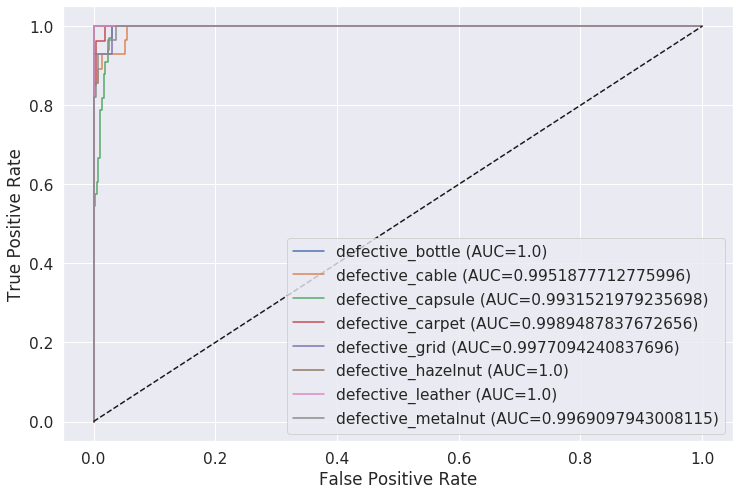

In [0]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[:8]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

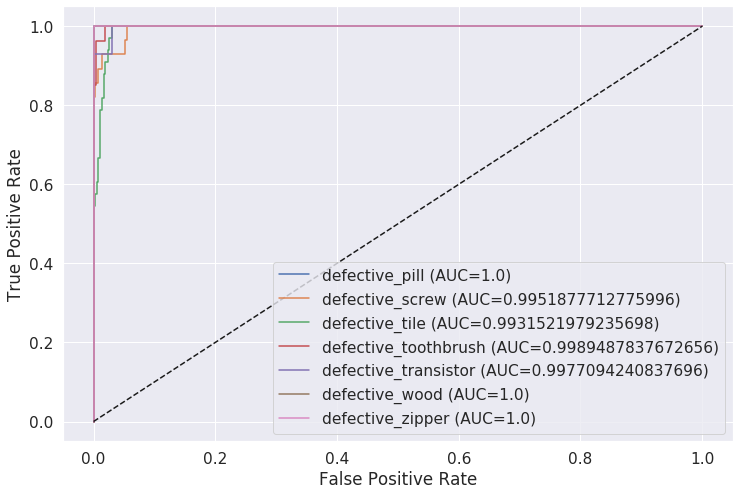

In [0]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[8:15]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

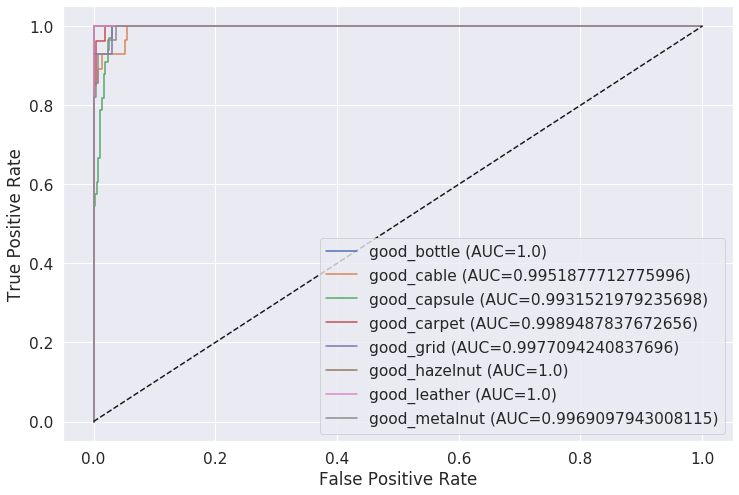

In [0]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[15:23]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

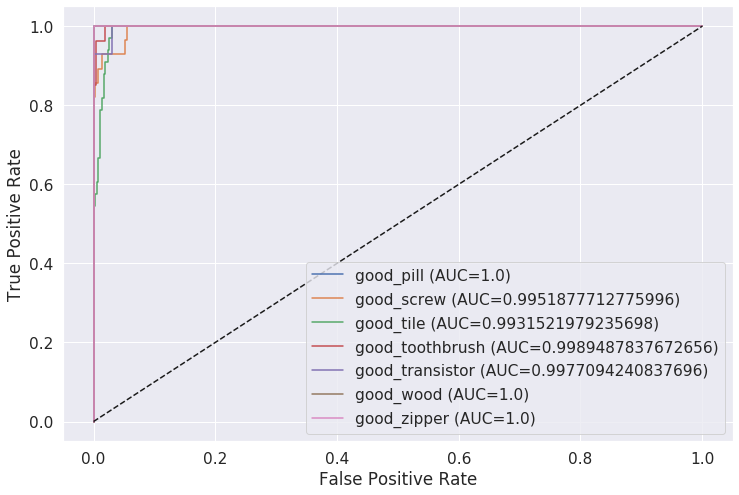

In [0]:
auc = []
fpr_def = []
tpr_def = []
for iter_class, c in enumerate(CLASSES[23:30]):
    class_target = (test_generator.labels == iter_class).astype('int')
    class_pred = predIndxs[:, iter_class]
    # Calculate AUC
    class_auc = roc_auc_score(class_target, class_pred)
    # Calculate TPR, FPR
    class_fpr, class_tpr, _ = roc_curve(class_target, class_pred)
    auc.append(class_auc)
    fpr_def.append(class_fpr)
    tpr_def.append(class_tpr)
    # Plot
    plt.plot(class_fpr, class_tpr, label=c + ' (AUC=' + str((class_auc)) + ')')
x = np.linspace(0, 1, num=100)
plt.plot(x, x, 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

fig = plt.gcf()
fig.set_size_inches(12, 8)

In [0]:
predIndxs_max = np.argmax(predIndxs, axis=1)
print(classification_report(test_generator.classes, predIndxs_max, target_names=test_generator.class_indices.keys()))

                      precision    recall  f1-score   support

    defective_bottle       1.00      0.89      0.94        19
     defective_cable       0.92      0.79      0.85        28
   defective_capsule       0.69      0.61      0.65        33
    defective_carpet       1.00      0.81      0.90        27
      defective_grid       1.00      0.57      0.73        14
  defective_hazelnut       1.00      0.95      0.98        21
   defective_leather       1.00      1.00      1.00        28
  defective_metalnut       0.89      0.61      0.72        28
      defective_pill       0.68      0.50      0.58        42
     defective_screw       0.50      0.06      0.11        17
      defective_tile       1.00      0.92      0.96        25
defective_toothbrush       1.00      0.56      0.71         9
defective_transistor       0.83      0.42      0.56        12
      defective_wood       1.00      0.89      0.94        18
    defective_zipper       1.00      0.97      0.99        36
       

In [0]:
print('Confusion matrix:')
cm = confusion_matrix(test_generator.classes,predIndxs_max)
print(cm)

total = sum(sum(cm))
print("Total test images: ", total)
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3] + cm[4, 4] + cm[5, 5] + cm[6, 6] +
       cm[7, 7] + cm[8, 8] + cm[9, 9] + cm[10, 10] + cm[11, 11] + cm[12, 12] +
       cm[13, 13] + cm[14, 14] + cm[15, 15] + cm[16, 16] + cm[17, 17] + cm[18, 18] +
       cm[19, 19] + cm[20, 20] + cm[21, 21] + cm[22, 22] + cm[23, 23] + cm[24, 24] +
       cm[25, 25] + cm[26, 26] + cm[27, 27] + cm[28, 28] + cm[29, 29]) / total
print("Accuracy: {:.3f}".format(acc))
print("Lables:")
print("x axis: Predicted")
print("y axis: Actual")

Confusion matrix:
[[ 17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  22   0   0   0   0   0   0   0   0   0   0   0   0   0   0   6   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  20   0   0   0   0   0   0   0   0   0   0   0   0   0   0  13
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  22   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    5   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   8   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   6   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  20   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  28   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  17   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  11   0   0   0

In [0]:
# normalized_cm = cm/total
# print('Normalized Confusion matrix:')
# print(normalized_cm)

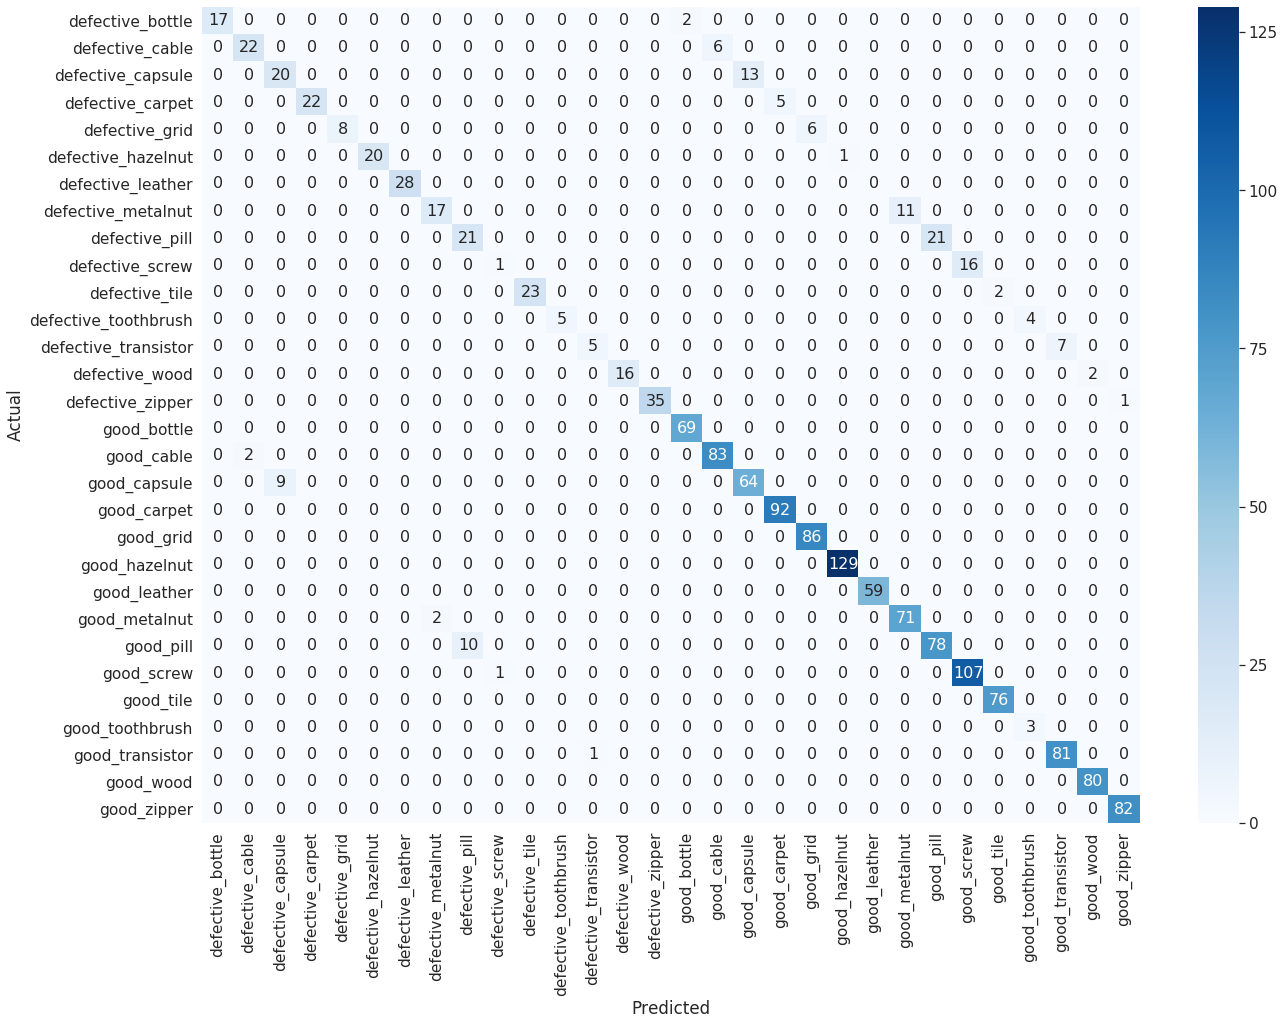

In [0]:
import seaborn as sn
    
plt_cm = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
plt.figure(figsize = (21,15))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="d")
# plt.savefig('/content/drive/My Drive/xai_model/MVTec_RN101_50_2_CM.jpg')

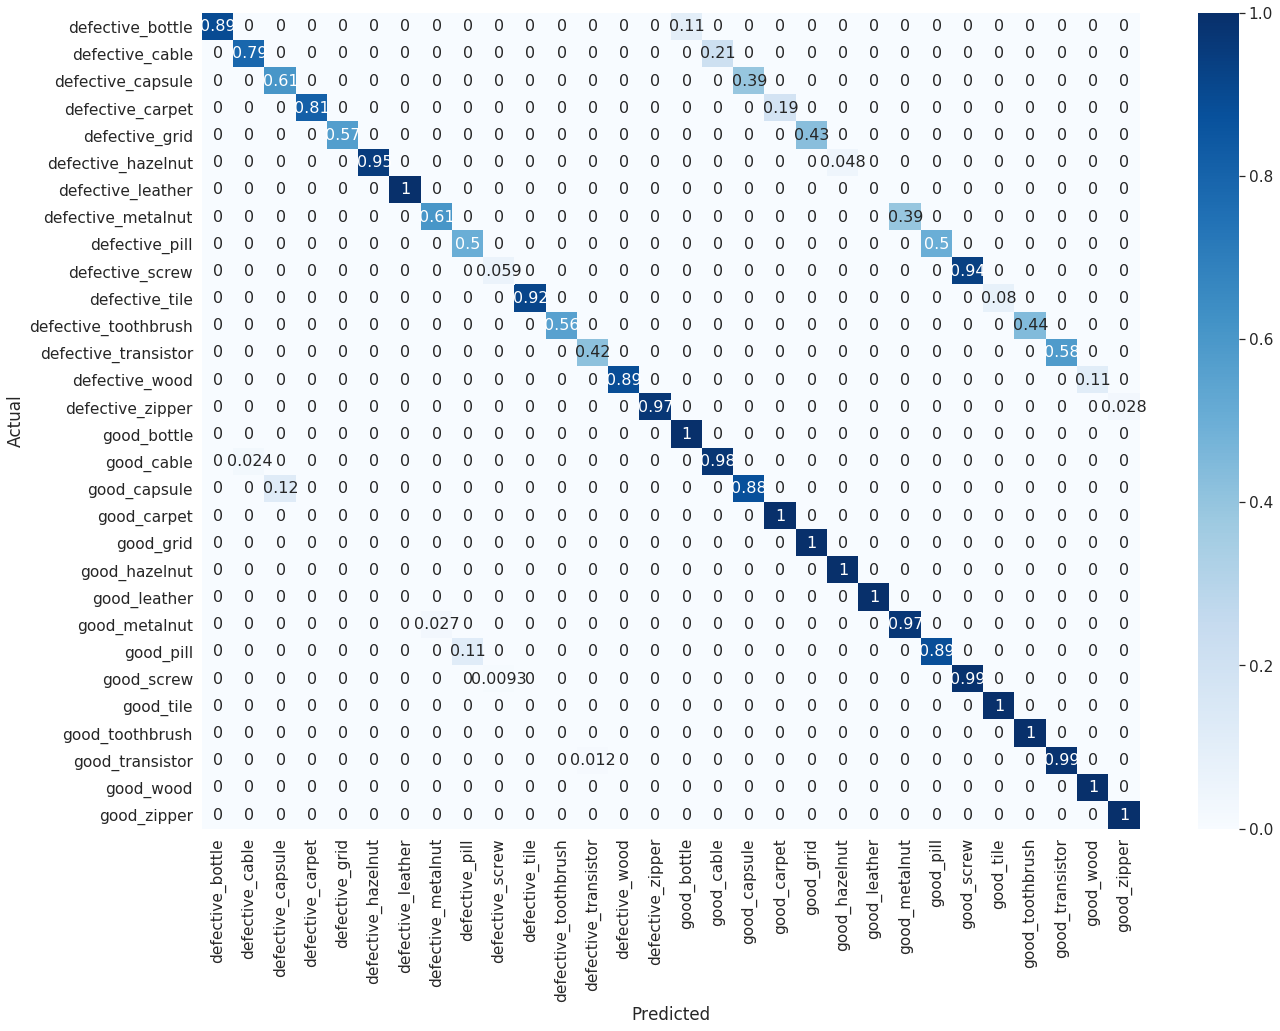

In [0]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt_cm = pd.DataFrame(cm_normalized, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = 'Actual'
plt_cm.columns.name = 'Predicted'
plt.figure(figsize = (21,15))
sn.set(font_scale=1.4)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
# plt.savefig('/content/drive/My Drive/xai_model/MVTec_RN101_50_2_CM_N.jpg')

# Prediction

In [0]:
image_path = "/content/drive/My Drive/data/test/defective_screw/screw_scratch_head_001.png"

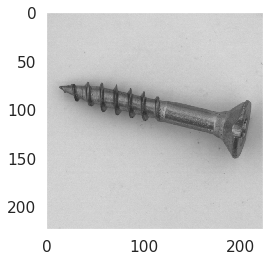

In [0]:
test_img = image.load_img(image_path, target_size=(224,224,3))
plt.grid(None)
plt.imshow(test_img)

test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

In [0]:
label_map_inv = {v:k  for k,v in label_map.items()}

result = model.predict(test_img)
print(result)

prediction = result.argmax(axis=1)
print(prediction)

output = label_map_inv[int(prediction)]
print("Output : ",output)

[[1.39407584e-05 1.13763472e-05 8.45212417e-05 1.77396250e-05
  2.98587347e-05 2.42182000e-06 1.04242617e-05 3.90353989e-06
  1.17008021e-05 3.28709036e-01 4.49600557e-05 1.45037975e-05
  1.84614255e-05 2.56943167e-05 8.01468559e-06 1.11925410e-05
  6.03065782e-05 3.25740039e-05 7.41646681e-06 4.10077482e-05
  3.11905478e-06 3.70895327e-06 7.73664942e-06 5.77594437e-06
  6.70753777e-01 2.41698272e-05 1.17514492e-05 1.08082304e-05
  1.13001806e-05 8.74536181e-06]]
[24]
Output :  good_screw


In [0]:
unique, counts_train = np.unique(train_generator.labels, return_counts=True)
print("Images per class in Training step: ",counts_train)
unique, counts_val = np.unique(val_generator.labels, return_counts=True)
print("\n Images per class in Validation step: ",counts_val)
unique, counts_test = np.unique(test_generator.labels, return_counts=True)
print("\n Images per class in Testing step : ",counts_test)

Images per class in Training step:  [ 36  52  61  50  26  40  52  52  80  33  48  17  23  34  67 128 158 136
 173 160 242 110 136 164 203 142   7 153 149 152]

 Images per class in Validation step:  [ 8 12 15 12  6  9 12 13 19  8 11  4  5  8 16 32 39 33 43 39 60 27 33 41
 50 35  1 38 37 38]

 Images per class in Testing step :  [ 19  28  33  27  14  21  28  28  42  17  25   9  12  18  36  69  85  73
  92  86 129  59  73  88 108  76   3  82  80  82]


In [0]:
# N = 30
# ind = np.arange(N)
# width = 0.5       # the width of the bars: can also be len(x) sequence

# p1 = plt.bar(ind, counts_train, width)
# p2 = plt.bar(ind, counts_val, width)
# p3 = plt.bar(ind, counts_test, width)

# # plt.ylabel('Scores')
# # plt.title('Scores by group and gender')
# # plt.xticks(ind, list(test_generator.class_indices.keys())[:5])
# # plt.yticks(np.arange(0, 81, 10))
# # plt.legend((p1[0], p2[0]), ('Men', 'Women'))
# # plt.figure(figsize = (21,15))
# # plt.grid(None)
# # plt.show()

# plt.grid(None)
# fig = plt.gcf()
# fig.set_size_inches(15, 8)

In [0]:
import plotly.graph_objects as go

headerColor = 'grey'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Class Labels</b>','<b>Training</b>','<b>Validation</b>','<b>Test</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      list(label_map.keys()),
      counts_train,
      counts_val,
      counts_test],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    # fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*30],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.update_layout(
    autosize=False,
    width=700,
    height=825,
    title_text = "Dataset distribution table"
)

fig.show()